# Eye Tracking Analysis
*by Viviane Kakerbeck*

#### Import Dependencies

In [1]:
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import ndimage
import scipy
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Arrow, Circle

#### Specify File Path

In [2]:
path = "./data/"
#impath = "/Users/ingen/Dropbox/artstyles/stimuli/"
impath = "C:/Users/vivia/Dropbox/artstyles/stimuli/"
#impath = "C:/Vivi's Dateien/Dropbox/artstyles/stimuli/"

### Notes About Data:
Subject 24 has three trials written in one (166)

Subject 38 is missing one trial in fix and blink

Subject 60 has a trial (144) with only one entry at t=-20

#### Helper Functions for Data Extraction and Cleaning/Fixing

In [3]:
def getFixations(data):
    fixationsx = []
    fixationsy = []
    trialnum = []
    tn = 1
    for i in range(len(data)):
        nfixX = []
        nfixY = []
        try:
            for j,fixX in enumerate(data[i].left.fixation.x):
                if data[i].left.fixation.start[j]>6000 and j<len(data[i].left.fixation.start)-1:#check that it isnt just one faulty number but a whole mixed trial
                    data[i].left.fixation.start[j:]=data[i].left.fixation.start[j:]-data[i].left.fixation.start[j]           
                    tn = tn+1
                if data[i].left.fixation.start[j]>0 and data[i].left.fixation.start[j]<6000:
                    nfixX = np.append(nfixX,fixX)
                    nfixY = np.append(nfixY,data[i].left.fixation.y[j])
                    trialnum = np.append(trialnum,tn)
            tn = tn+1
            fixationsx = np.append(fixationsx,np.array(nfixX))
            fixationsy = np.append(fixationsy,np.array(nfixY))
        except:
            print("skipped "+str(i)+"  "+str(j+2))
    return fixationsx,fixationsy,trialnum

def getTrialFixations(data):
    fixationsx = []
    fixationsy = []
    trialnum = []
    blocks = []
    groups = []
    styles = []
    tn = 1
    for i in range(len(data)):
        nfixX = []
        nfixY = []
        try:
            splitp = 0
            for j,fixX in enumerate(data[i].left.fixation.x):
                if data[i].left.fixation.start[j]>6000 and j<len(data[i].left.fixation.start)-1:#check that it isnt just one faulty number but a whole mixed trial
                    data[i].left.fixation.start[j:]=data[i].left.fixation.start[j:]-data[i].left.fixation.start[j]           
                    tn = tn+1
                    splitp = j
                if data[i].left.fixation.start[j]>0 and data[i].left.fixation.start[j]<6000:
                    nfixX = np.append(nfixX,fixX)
                    nfixY = np.append(nfixY,data[i].left.fixation.y[j])
                    trialnum = np.append(trialnum,tn)
            tn = tn+1
            fixationsx = np.append(fixationsx,np.array(nfixX))
            fixationsy = np.append(fixationsy,np.array(nfixY))
            if splitp==0:
                blocks = np.append(blocks,np.full(len(nfixX),int(data[i].block.msg)))
                groups = np.append(groups,np.full(len(nfixX),int(data[i].group.msg)))
                styles = np.append(styles,np.full(len(nfixX),int(data[i].style.msg)))
            else:
                if data[i].left.fixation.start[0]>0:
                    n = 0
                else:
                    n = np.argmin(data[i].left.fixation.start<=0)#get first index where fixation time is >0
                blocks = np.append(blocks,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].block.msg[0])))
                blocks = np.append(blocks,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].block.msg[1])))
                groups = np.append(groups,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].group.msg[0])))
                groups = np.append(groups,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].group.msg[1])))
                styles = np.append(styles,np.full(len(data[i].left.fixation.start[n:splitp]),int(data[i].style.msg[0])))
                styles = np.append(styles,np.full(len(data[i].left.fixation.start[splitp+1:]),int(data[i].style.msg[1])))
        except:
            print("skipped "+str(i)+"  "+str(j+2))
    return fixationsx,fixationsy,trialnum,blocks,groups,styles

def getBlinks(data):
    blinks = []
    trialnum = []
    tn = 1
    for i in range(len(data)):
        bls = []
        split = False
        if isinstance(data[i].left.blink.start,int):
            if data[i].left.blink.start>6000:
                bls = np.append(bls,0)
                trialnum = np.append(trialnum,tn)
                tn = tn+1
                split = True
            if data[i].left.blink.start<0:
                bls = np.append(bls,0)
                trialnum = np.append(trialnum,tn)
            if data[i].left.blink.start>=0 and data[i].left.blink.start<6000:
                bls = np.append(bls,data[i].left.blink.start)
                trialnum = np.append(trialnum,tn)                
        else:            
            for j in range(len(data[i].left.blink.start)):
                if data[i].left.blink.start[j]>6000 and j<len(data[i].left.blink.start):
                    data[i].left.blink.start[j:]=data[i].left.blink.start[j:]-(data[i].left.blink.start[j]+1)
                    data[i].left.blink.end[j:]=data[i].left.blink.end[j:]-(data[i].left.blink.end[j]+1)
                    tn = tn+1
                    split = True
                if data[i].left.blink.start[j]>=0 and data[i].left.blink.start[j]<6000:
                    bls = np.append(bls,data[i].left.blink.start[j])
                    trialnum = np.append(trialnum,tn)
                if data[i].left.blink.start[j]<0:
                    bls = np.append(bls,0)
                    trialnum = np.append(trialnum,tn)
        if np.any(data[i].left.fixation.start>6000) and split == False:#case when cells were merged but second trial had no blinks
            tn = tn+1
            bls = np.append(bls,0)
            trialnum = np.append(trialnum,tn)
        tn = tn+1
        blinks = np.append(blinks,np.array(bls))
    return blinks,trialnum

## Plot Heatmaps for all Subjects
- Plot Size = Screen Size
- Blue Square = Stimulus size
- Blue Dot = Center of the screen
- Red Dot = Location of highest fixation density

In [ ]:
#From experiment code:

#ScreenRes = 1280 1024
#Image size = 824 824
#init_row = winHeight/2-img_width/2;%round((winHeight - size(painting, 1))) + 1
#end_row = init_row+img_width;%init_row + size(painting, 1)-1;
#init_col_right = winWidth/2-img_width/2;%size(painting, 2) + gap;
#stimulus(init_row:end_row-1, init_col_right:init_col_right+img_width-1, :) = painting(:, 1:img_width, :);

#-> init_row = 1024/2-824/2 = 100
#-> end_row = 100+824 = 924
#-> init_col_right = 1280/2-824/2 = 228
#-> end_col = 228+824 = 1052

skipped 143  4


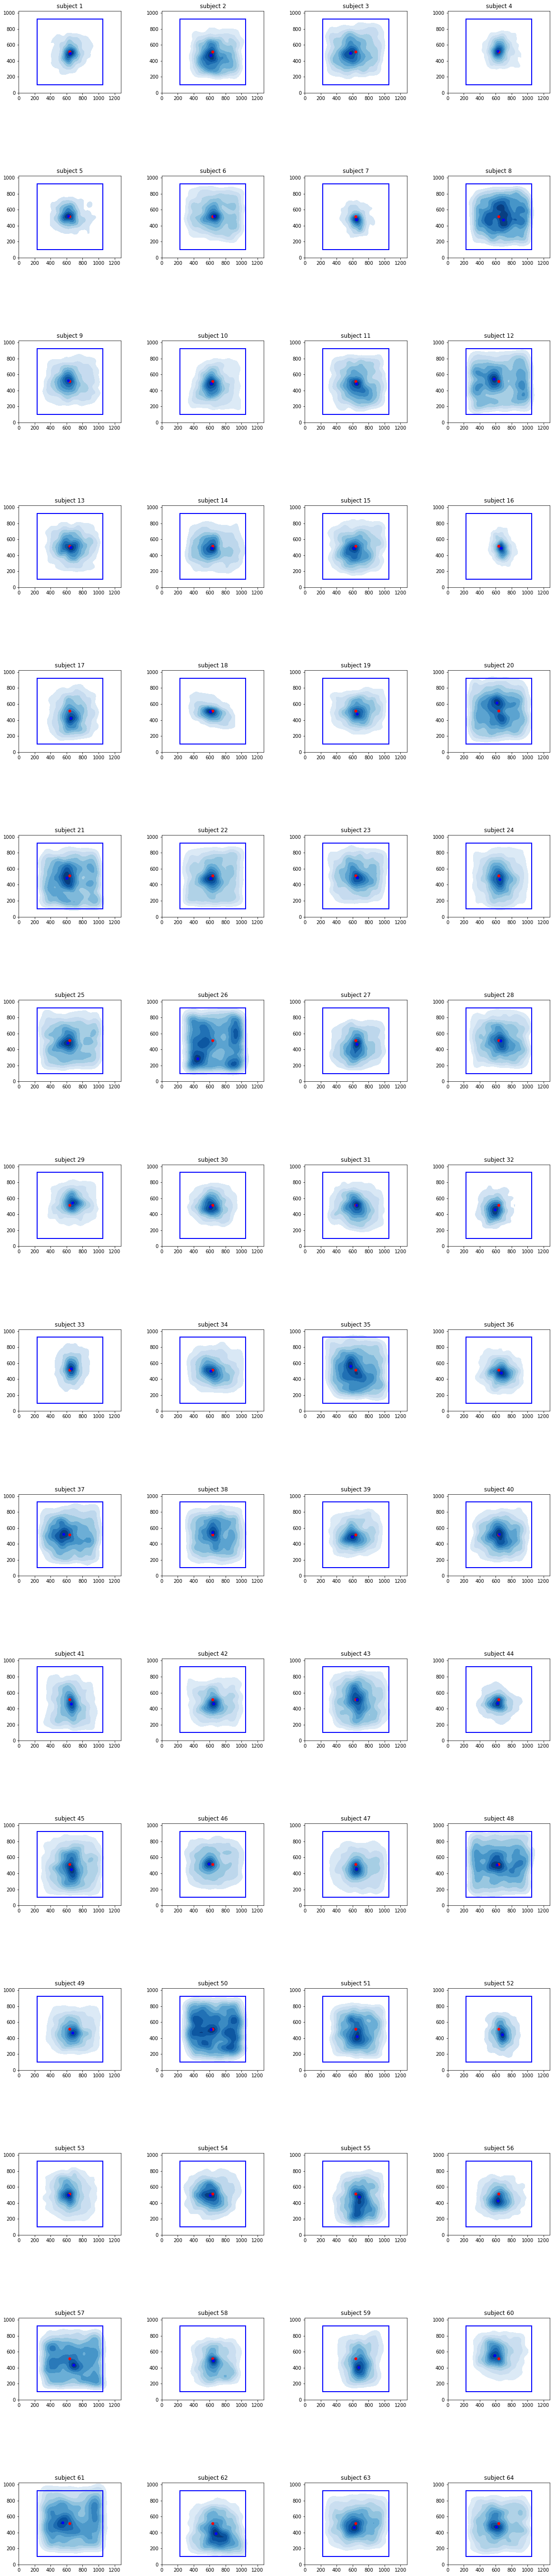

In [4]:
fig = plt.figure(figsize=(20,100))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
biasx = []
biasy = []
for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    
    xy = np.vstack([fx,fy])
    kde = scipy.stats.gaussian_kde(xy)
    density = kde(xy)
    dx,dy = xy.T[np.argmax(density)]
    
    biasx = np.append(biasx,1280/2-dx)
    biasy = np.append(biasy,1024/2-dy)
    
    ax = fig.add_subplot(16, 4, s+1)
    ax.set_title("subject "+str(s+1))
    plt.xlim(0,1280)
    plt.ylim(0,1024)
    ax.set(aspect="equal")

    sns.kdeplot(fx, fy, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,
    
    plt.plot([228, 228],[100, 924], linewidth=2, color='b')
    plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
    plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
    plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
    ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
    ax.add_patch(Circle((dx,dy), radius=15, color='blue'))
    

#plt.savefig('Results/SubjectHeatmaps.png')

### Plot the Distribution over Subjects of the Location of the Point of Highest Fixation Density

Text(0.5,0,'Distance Between Center and Densest Point')

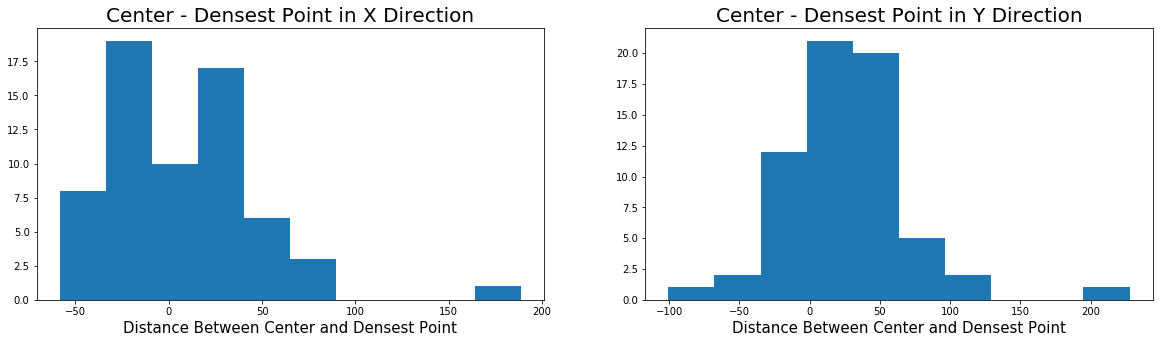

In [5]:
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(biasx)
plt.title('Center - Densest Point in X Direction', fontsize=20)
plt.xlabel('Distance Between Center and Densest Point',fontsize=15)
plt.subplot(122)
plt.hist(biasy)
plt.title('Center - Densest Point in Y Direction', fontsize=20)
plt.xlabel('Distance Between Center and Densest Point',fontsize=15)
#plt.savefig('Results/BiasDist.png')

## Get Some Overall Fixation Statistics

In [6]:
allfixX = []
allfixY = []
XVars = []
YVars = []

for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    fx,fy,t = getFixations(data)
    Keep = (fx>200) & (fx<1100) & (fy<1000) & (fy>0)
    t = t[Keep]
    fx = fx[Keep]
    fy = fy[Keep]
    
    allfixX = np.append(allfixX,fx)
    allfixY = np.append(allfixY,fy)
    
    XVars = np.append(XVars,np.var(fx))
    YVars = np.append(YVars,np.var(fy))

skipped 143  4


### Plot the Variance Over Fixation Locations in X and Y Direction

Text(0.5,1,'Variance Distribution in Y Direction')

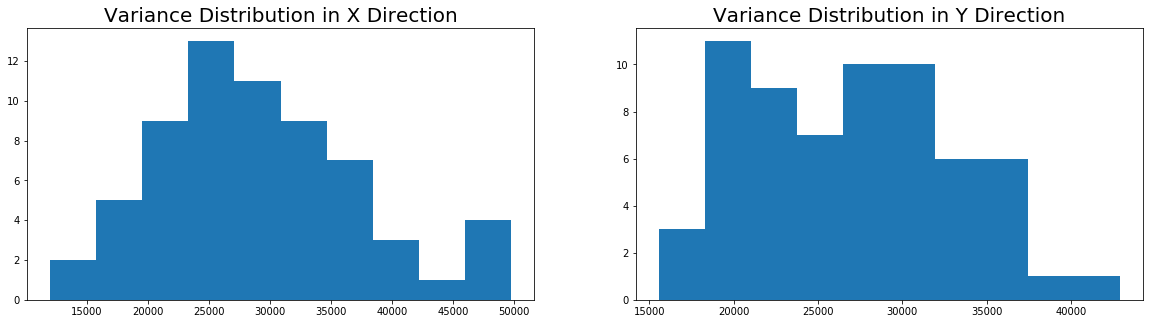

In [7]:
fig = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(XVars)
plt.title('Variance Distribution in X Direction', fontsize=20)
plt.subplot(122)
plt.hist(YVars)
plt.title('Variance Distribution in Y Direction', fontsize=20)
#plt.savefig('Results/VarDists.png')

In [8]:
print('Mean X: '+str(np.mean(allfixX))+"  Mean Y: "+str(np.mean(allfixY))+"  Var X: "+str(np.var(allfixX))+"  Var Y: "+str(np.var(allfixY)))

Mean X: 659.5634161099644  Mean Y: 499.20834635352907  Var X: 29797.653960331925  Var Y: 27725.44940095406


In [9]:
print('Median X: '+str(np.median(allfixX))+"  Median Y: "+str(np.median(allfixY)))


Median X: 653.73046875  Median Y: 493.8458251953125


### Plot the Fixation Density Map Over all Subjects

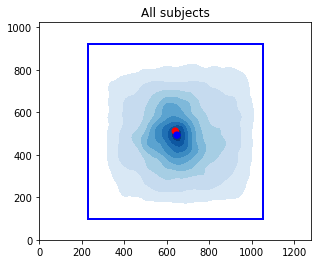

In [10]:
fig = plt.figure()
xy = np.vstack([allfixX,allfixY])
kde = scipy.stats.gaussian_kde(xy)
density = kde(xy)
dx,dy = xy.T[np.argmax(density)]

biasx = 1280/2-dx
biasy = 1024/2-dy

ax = fig.add_subplot(1, 1, 1)
ax.set_title("All subjects")
plt.xlim(0,1280)
plt.ylim(0,1024)
ax.set(aspect="equal")

sns.kdeplot(allfixX, allfixY, shade=True, shade_lowest = False,ax=ax, cmap="Blues")#shade=True,

plt.plot([228, 228],[100, 924], linewidth=2, color='b')
plt.plot([1052, 1052],[100, 924], linewidth=2, color='b')
plt.plot([228, 1052],[100, 100], linewidth=2, color='b')
plt.plot([228, 1052],[924, 924], linewidth=2, color='b')
ax.add_patch(Circle((1280/2, 1024/2), radius=15, color='red'))
ax.add_patch(Circle((dx,dy), radius=15, color='blue'))

In [11]:
print("mean X: "+str(dx)+" mean Y:"+str(dy))

mean X: 647.8064575195312 mean Y:492.98187255859375


Text(0.5,1,'Fixation Distribution for all Subjects')

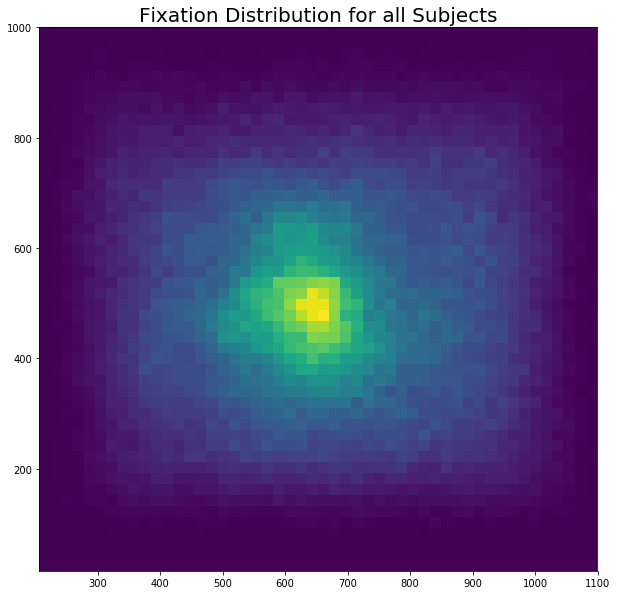

In [12]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(allfixX,allfixY, bins=50)
plt.title('Fixation Distribution for all Subjects',fontsize=20)
#plt.show()
#plt.savefig('Results/FixDistAll.png')

## Overall Blink Analysis

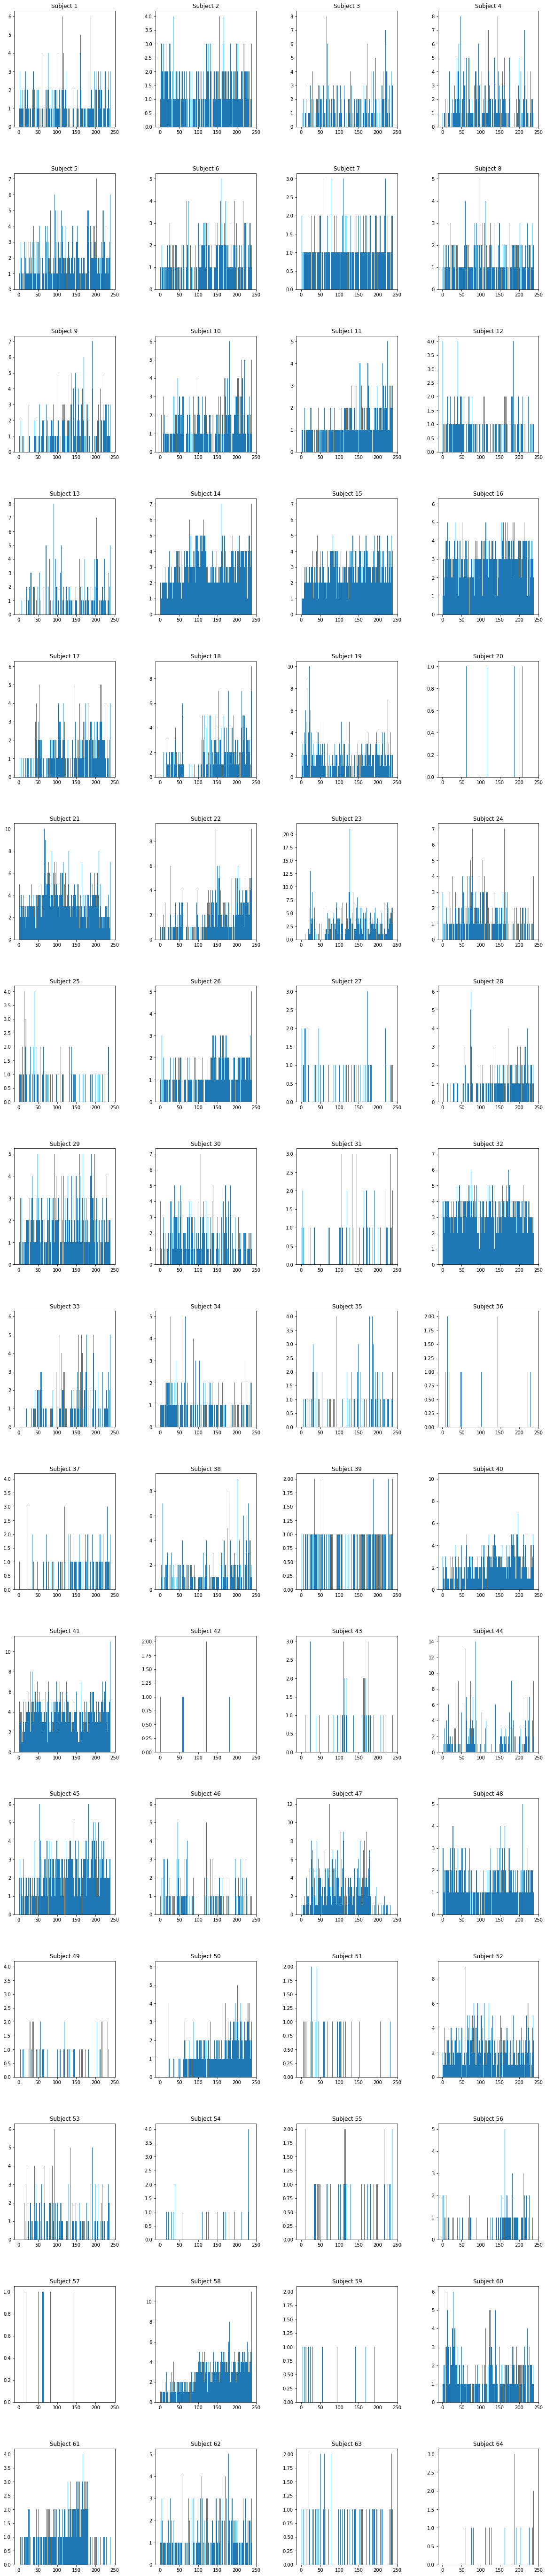

In [13]:
fig = plt.figure(figsize=(20,100))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    b,t = getBlinks(data)
    
    Keep = (b>0)
    t = t[Keep]
    b = b[Keep]
    
    ax = fig.add_subplot(16, 4, s+1)

    plt.hist(t, bins=range(0, 240, 1))
    ax.set_title("Subject "+str(s+1))
#plt.savefig('Results/SubjectBlinks.png')

#### Calculate Overall Blink Distributions

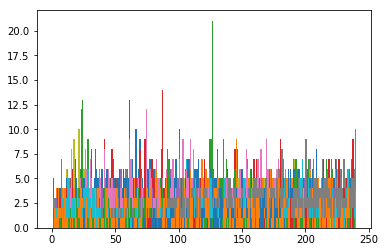

In [14]:
blinkNums = []
blinks = np.zeros((64,240))
for s in range(64):
    if s<9:
        num = '00'+str(s+1)
    else:
        num = '0'+str(s+1)
    mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
    data = mat['file']
    b,t = getBlinks(data)
    
    Keep = (b>0)
    t = t[Keep]
    b = b[Keep]
    
    (n, bins2, patches) = plt.hist(t, bins=range(0, 241, 1))
    blinkNums = np.append(blinkNums,n)
    blinks[s] = n

### Plot the Dictribution of Blinks per Trial

Text(0.5,1,'Distribution of Number of Blinks per Trial')

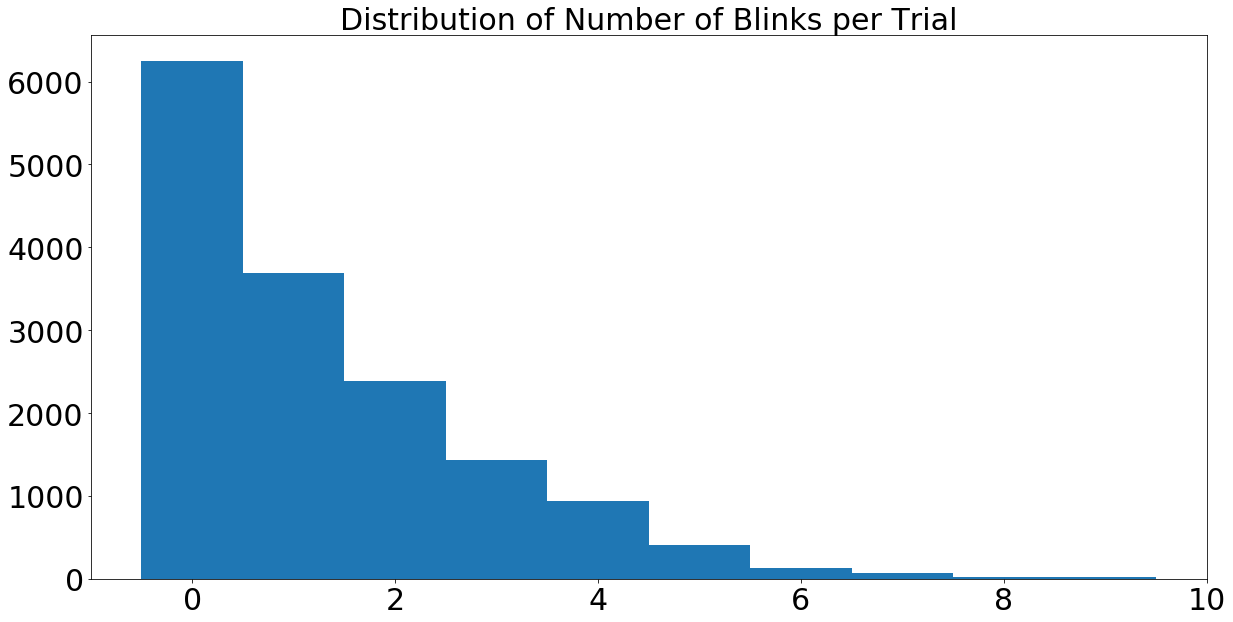

In [15]:
fig = plt.figure(figsize=(20,10))
plt.hist(blinkNums, bins=(np.arange(11)-0.5), range=(0, 11))
plt.tick_params(labelsize=30)
plt.title('Distribution of Number of Blinks per Trial',fontsize=30)
#plt.show()
#plt.savefig('Results/BlinkDist.png')

In [16]:
np.min(np.mean(blinks,axis=1))

0.016666666666666666

### Plot the Distribution of Average Number of Blinks Over Subjects

Text(0.5,0,'Average Number of Blinks per Trial')

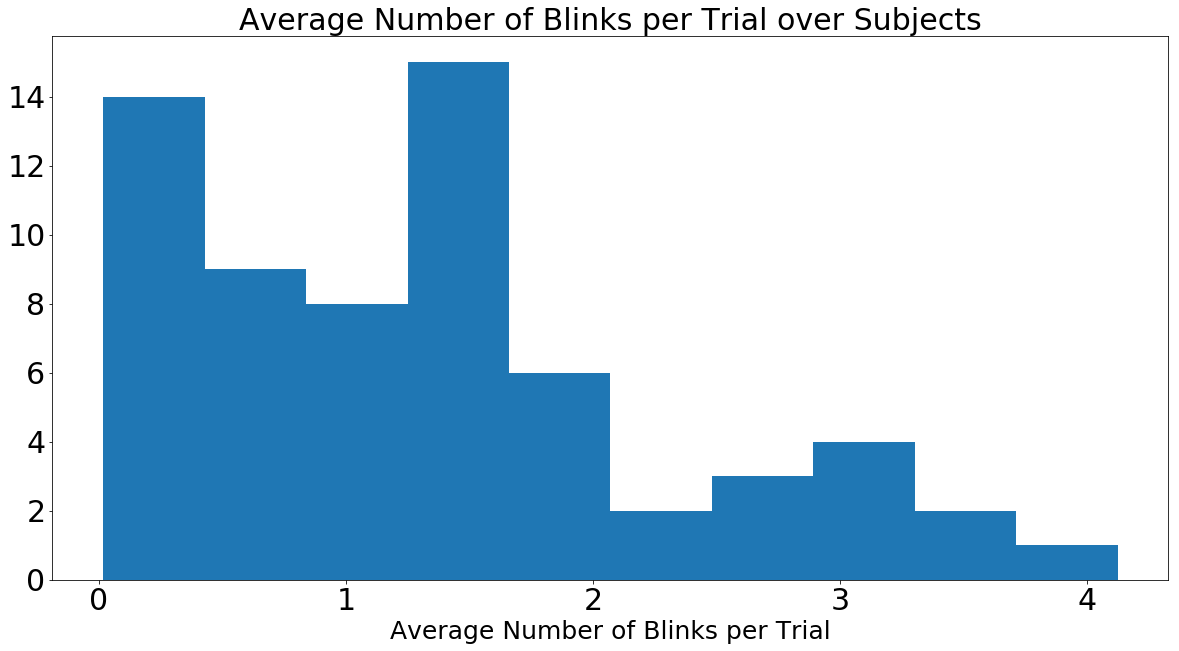

In [17]:
fig = plt.figure(figsize=(20,10))
plt.hist(np.mean(blinks,axis=1))
plt.tick_params(labelsize=30)
plt.title('Average Number of Blinks per Trial over Subjects',fontsize=30)
plt.xlabel("Average Number of Blinks per Trial", fontsize = 25)
#plt.savefig('Results/NumAvgBlinks.png')

# Style Comparisons

### Calculate Heatmaps for Each Picture (Only Run Once!)

In [ ]:
heatmaps = np.zeros((8,8,30,10,10))#heatmap[style][group][block][xcount][ycount]
blockdist = np.zeros((8,8,30))
Discard = [24]
#in folder structure: stimuli/stylenum/groupnum/blocknum
#same image with different style: stylex/gn/bn == styley/gn/bn
#8 trials per block, one of each style
for s in range(64):
    print(s)
    if (s+1) in Discard:
        print(str(s+1)+" discarded.")
    else:
        if s<9:
            num = '00'+str(s+1)
        else:
            num = '0'+str(s+1)
        mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
        data = mat['file']
        fx,fy,t,b,g,st = getTrialFixations(data)
        for num in range(1,241):
            PickRange = np.where(t==num)

            style = np.unique(st[PickRange])#1-8
            group = np.unique(g[PickRange])#0-7
            block = np.unique(b[PickRange])#1-30
            #print(str(int(style)-1)+"  "+str(int(group)-1)+"  "+str(int(block)-1))
            h = plt.hist2d(fx[PickRange],fy[PickRange], bins=10,range= [[200, 1100], [0, 1000]])
            #print(str(s)+"  "+str(num))
            try:
                #heatmaps[int(style)-1][int(group)][int(block)-1]=heatmaps[int(style)-1][int(group)][int(block)-1] + h[0]
                blockdist[int(style)-1][int(group)][int(block)-1]=blockdist[int(style)-1][int(group)][int(block)-1]+1
            except:
                try:
                    #print("Mixed Files at Subject "+str(s)+" Trial "+str(num))
                    #heatmaps[int(style[-1])-1][int(group[-1])][int(block[-1])-1]=heatmaps[int(style[-1])-1][int(group[-1])][int(block[-1])-1] + h[0]
                    blockdist[int(style[-1])-1][int(group[-1])][int(block[-1])-1]=blockdist[int(style[-1])-1][int(group[-1])][int(block[-1])-1]+1
                except:
                    print("Problem with "+str(s+1)+" Trial "+str(num))
                    print(str(style),str(group),str(block))
    #t = trial (1-240)
    #b = block (1-30)
    #g = group (0-7)
    #st = style (0-7)
    #print(str(len(fx))+"  "+str(len(b))+"  "+str(len(g))+"  "+str(len(st))+"  "+str(s+1)+"  "+str(len(fx)==len(b)==len(g)==len(st)))
    
    

In [ ]:
np.save('heatmaps.npy',heatmaps)
np.save('blockdist.npy',blockdist)

### Load Heatmaps

In [18]:
heatmaps = np.load('heatmaps.npy')
blockdist = np.load('blockdist.npy')

### Plot Some Samples

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


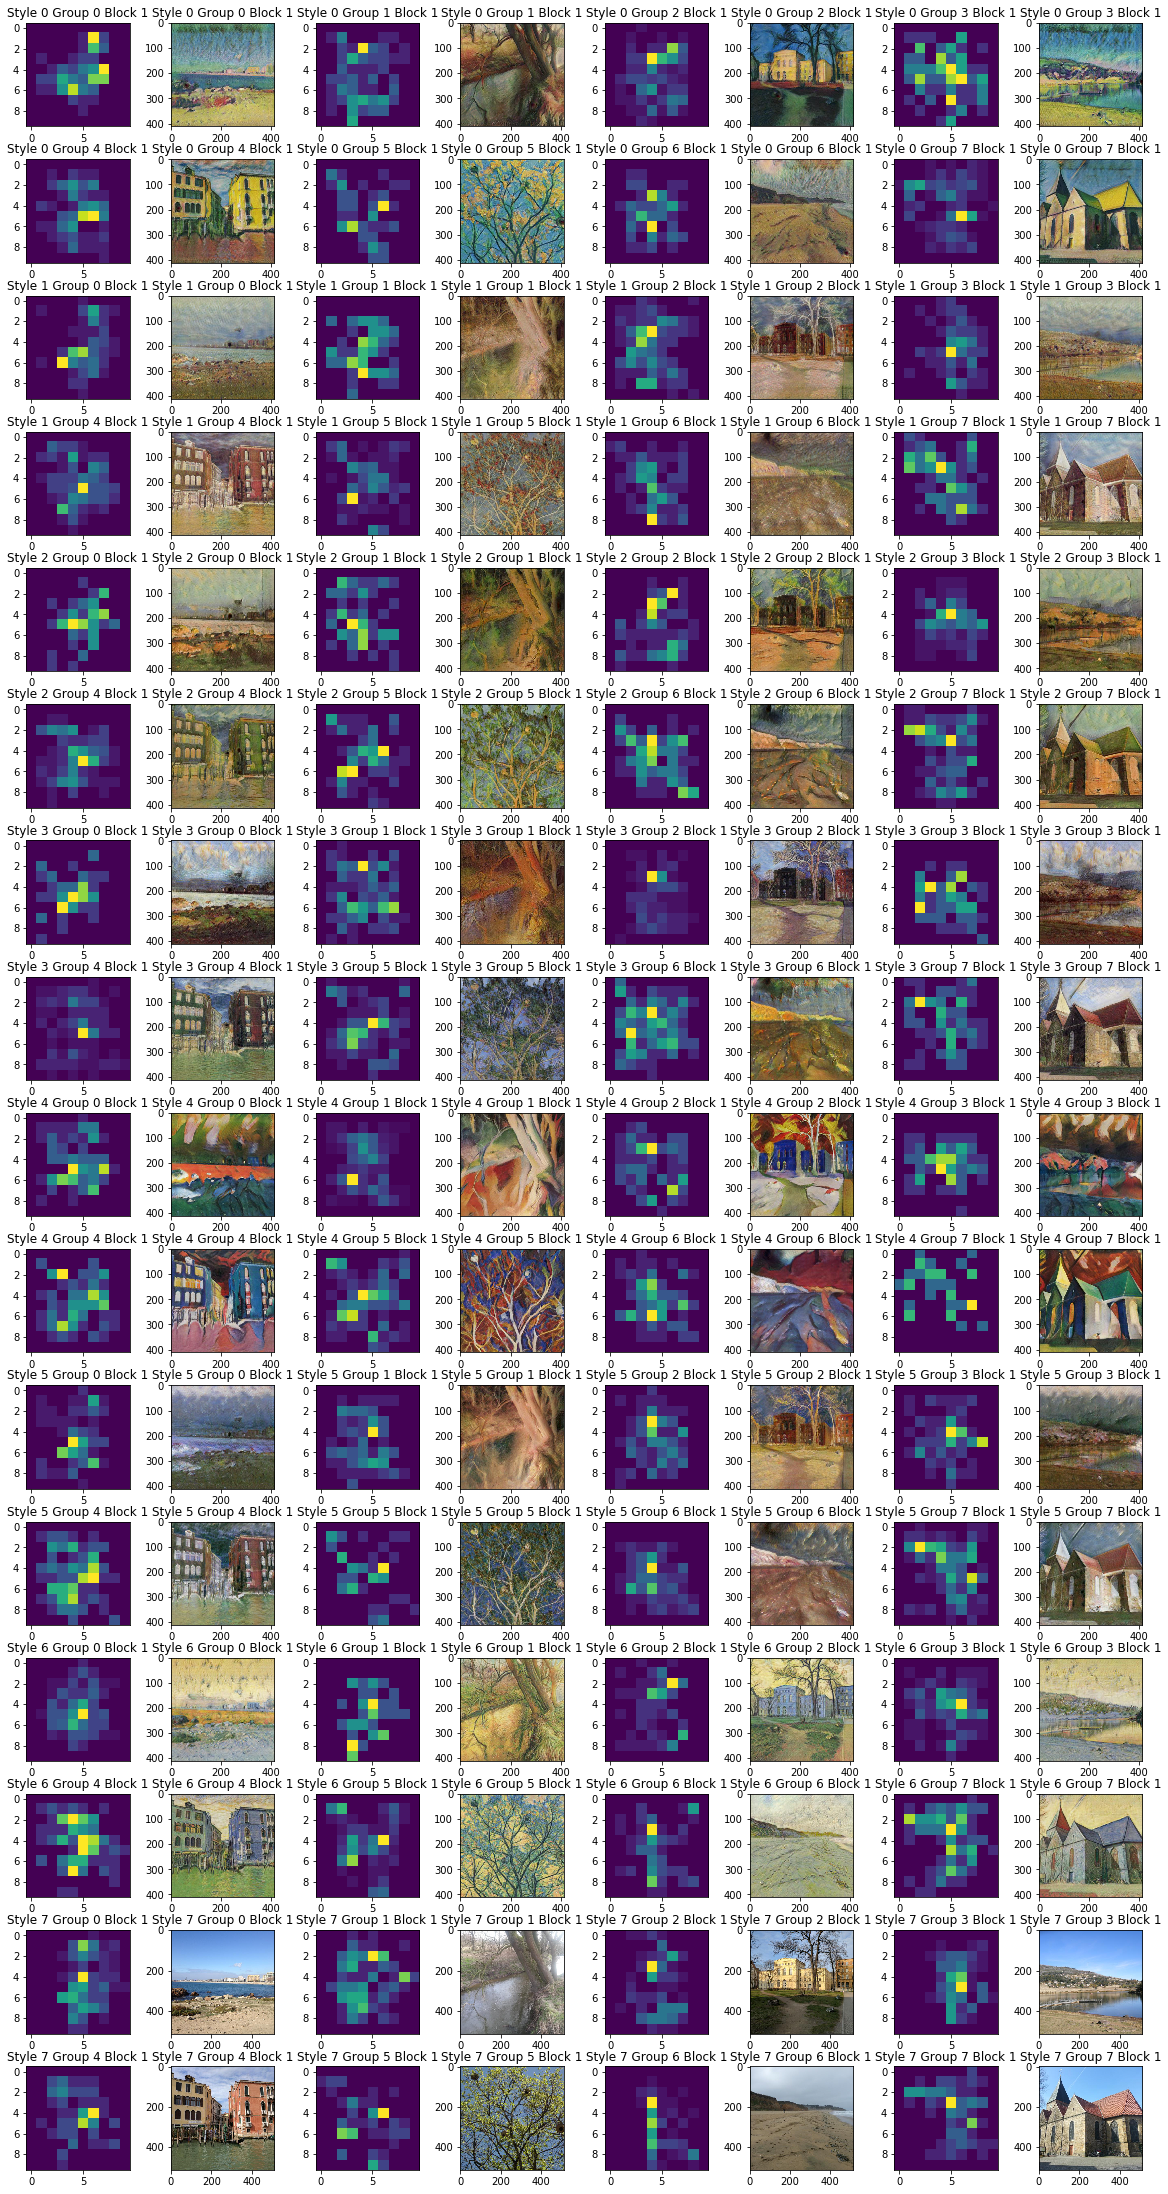

In [19]:
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(hspace=0.04, wspace=0.4)
n = 1
for s in range(8):
    for g in range(8):
        for b in range(1):
            ax = fig.add_subplot(2*8, 8, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            plt.imshow(heatmaps[s][g][b])
            n = n+1
            ax = fig.add_subplot(2*8, 8, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            im = scipy.ndimage.imread(impath+str(s)+"/"+str(g)+"/"+str(b+1)+".jpg")
            plt.imshow(im)
            n = n+1
plt.show()
#plt.savefig('Results/HeatmapSamples.png')

#### Checkout Beach Picture

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


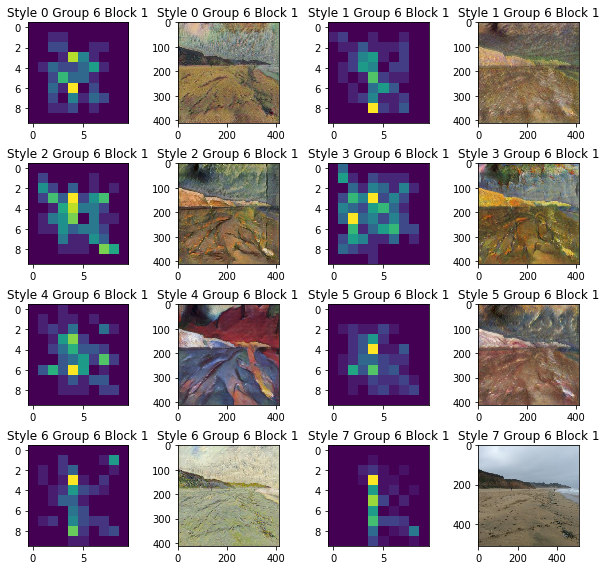

In [20]:
fig = plt.figure(figsize=(10,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n = 1
for g in range(1):
    g = 6
    for b in range(1):
        b = 0
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
            ax = fig.add_subplot(8, 4, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            plt.imshow(pictureHM[s])
            n = n+1
            ax = fig.add_subplot(8, 4, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            im = scipy.ndimage.imread(impath+str(s)+"/"+str(g)+"/"+str(b+1)+".jpg")
            plt.imshow(im)
            n = n+1 
plt.show()

# Over All Artstyle Analysis

#### Some Helper Functions

In [21]:
def normalize(data):  
    #norm = np.linalg.norm(data.flatten())
    norm = np.sum(data.flatten())
    normalized = data.flatten()/norm
    return normalized.reshape(data.shape)
def Correlate(h1,h2):
    return scipy.stats.pearsonr(normalize(h1).flatten(),normalize(h2).flatten())
def Differences(h1,h2):
    a = normalize(h1).flatten()
    b = normalize(h2).flatten()
    return np.linalg.norm(a-b)
def normalizeOld(data):
    xmax, xmin = data.max(), data.min()
    out = (data - xmin)/(xmax - xmin)
    return out

### Calculate Normalized Heatmaps for Each Art Style

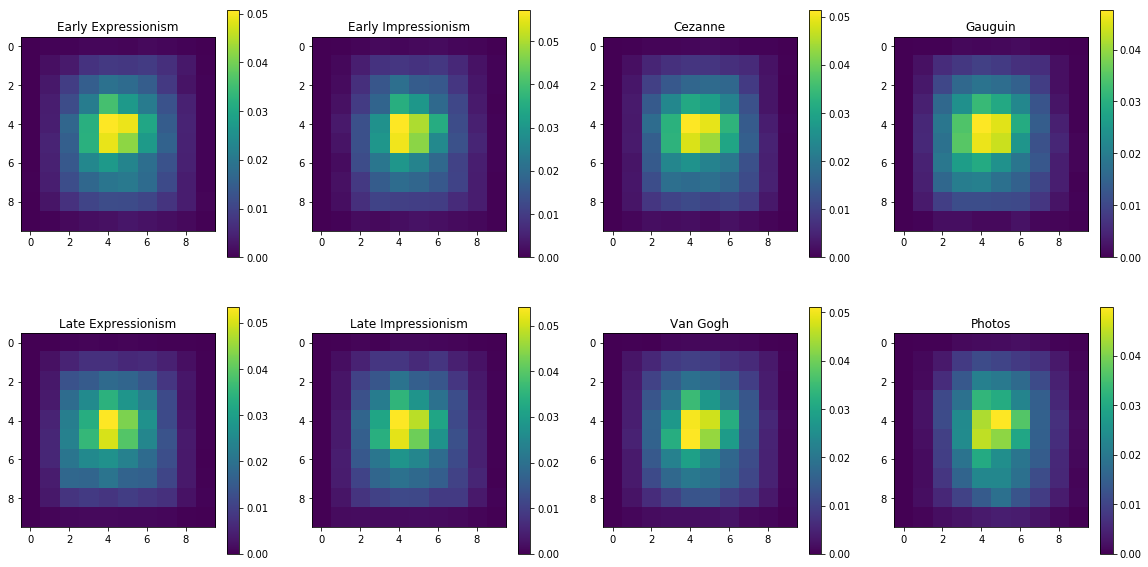

In [24]:
styles = ['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos']
fig = plt.figure(figsize=(20,10))
stylesHeat = np.zeros((8,10,10))
for s in range(8):
    for g in range(8):
        for b in range(30):
            stylesHeat[s] = stylesHeat[s]+heatmaps[s][g][b]
    ax = fig.add_subplot(2,4, s+1)
    ax.set_title(str(styles[s]))
    plt.imshow(normalize(stylesHeat[s]))
    plt.colorbar()
plt.savefig('Results/StyleFix.png')
#plt.show()

### Plot the Differences Between Style Heatmaps

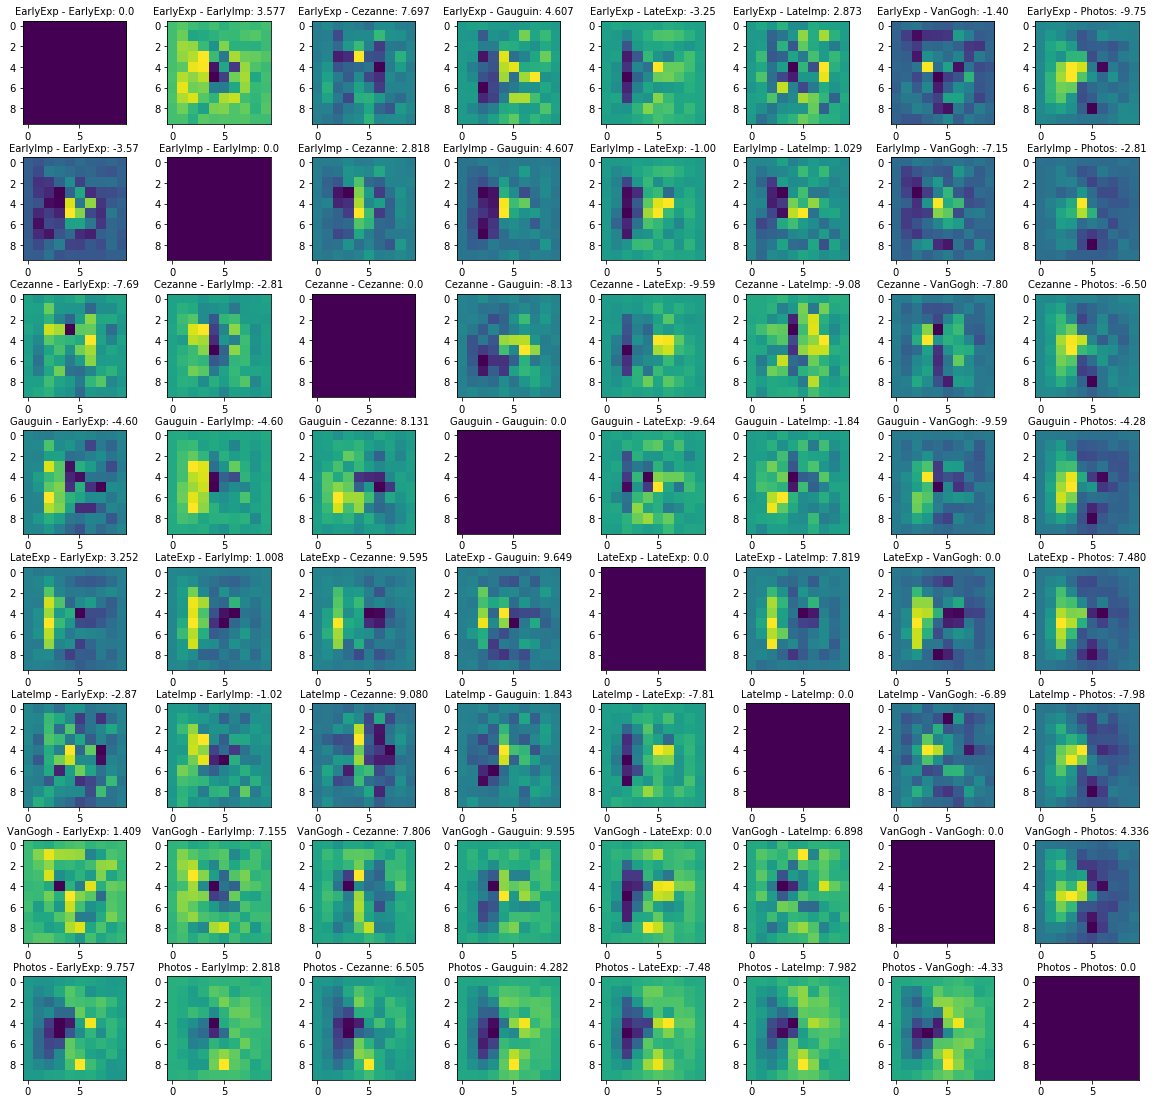

In [142]:
stylesShort = ['EarlyExp', 'EarlyImp', 'Cezanne', 'Gauguin', 'LateExp', 'LateImp', 'VanGogh','Photos']
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.04, wspace=0.4)
n = 1
differences = np.zeros((8,8))
correlations = np.zeros((8,8))
ps = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        ax = fig.add_subplot(8, 8, n)
        ax.set_title(str(stylesShort[i]+" - "+str(stylesShort[j])+": "+str(np.sum(normalize(stylesHeat[i])-normalize(stylesHeat[j])))[:5]),fontsize=10)
        plt.imshow(normalize(stylesHeat[i])-normalize(stylesHeat[j]))
        differences[i,j] = Differences(stylesHeat[i],stylesHeat[j])
        correlations[i,j] = Correlate(stylesHeat[i],stylesHeat[j])[0]
        ps[i,j] = Correlate(stylesHeat[i],stylesHeat[j])[1]
        n = n+1 
plt.show()        
#plt.savefig('Results/StyleFixDiff.png')

### Calculate and Plot a Correlation Matrix Between all Styles (Pearson Correlation)

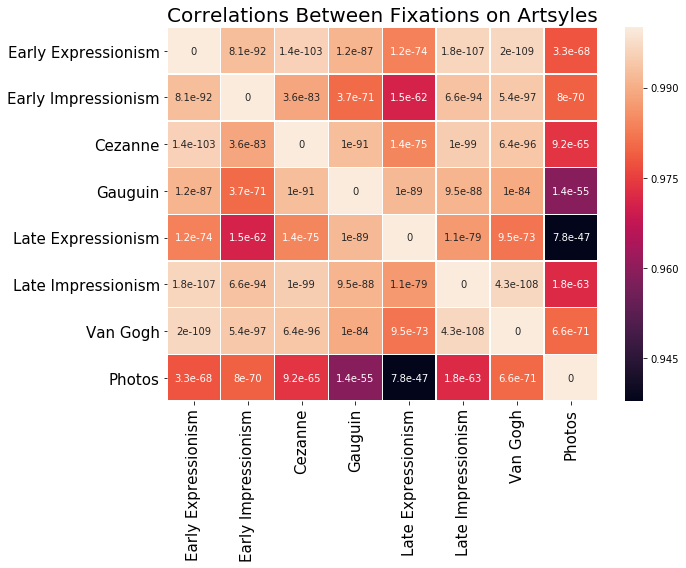

In [143]:
dfCor = pd.DataFrame(correlations, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])

#sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dfCor, linewidths=.5, ax=ax, annot = ps)

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlations Between Fixations on Artsyles",fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('Results/CorrStyleFixOneExp.png')

### Calculate and Plot a Difference Matrix Between all Styles (norm(a-b))

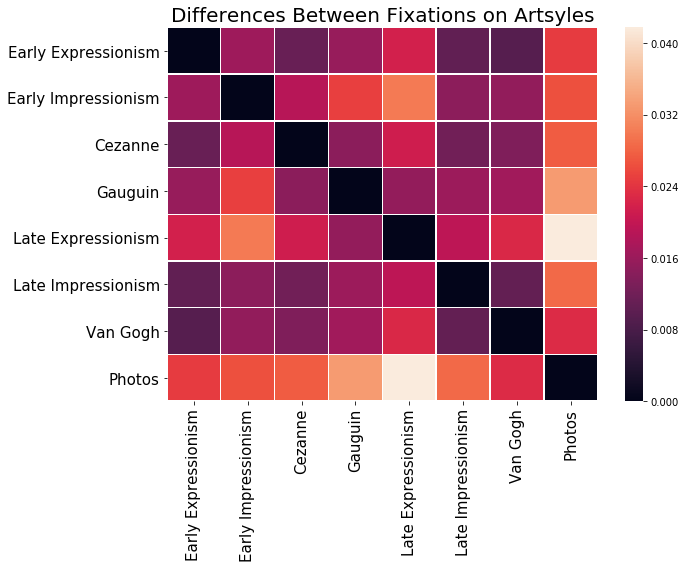

In [144]:
df = pd.DataFrame(differences, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])

#sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df, linewidths=.5, ax=ax)

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Differences Between Fixations on Artsyles",fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('Results/DiffStyleFixOneExp.png')

### Create a Hierarchical Clustering Based on the Difference Matrix

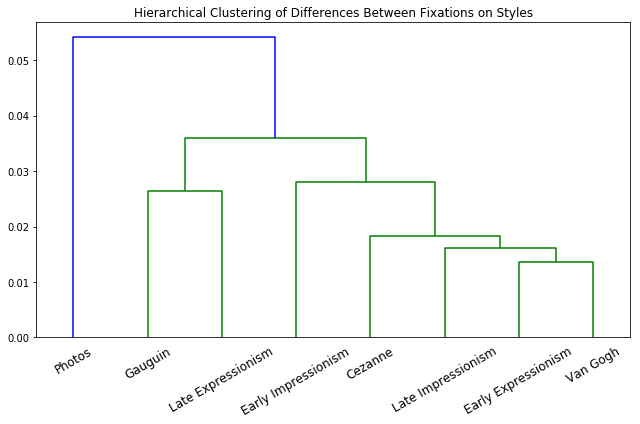

In [146]:
Z = linkage(1-differences, 'average')
f, ax = plt.subplots(figsize=(9, 6))
dn = dendrogram(Z,labels=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
plt.xticks(rotation=30)
plt.title("Hierarchical Clustering of Differences Between Fixations on Styles")
plt.tight_layout()
#plt.show()
plt.savefig('Results/DiffStyleFixCluster.png')

### Create a Hierarchical Clustering Based on the Correlation Matrix

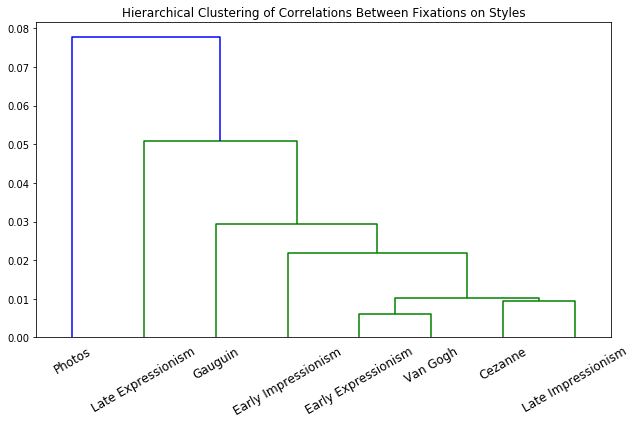

In [30]:
Z = linkage(correlations, 'average')
f, ax = plt.subplots(figsize=(9, 6))
dn = dendrogram(Z,labels=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
plt.xticks(rotation=30)
plt.title("Hierarchical Clustering of Correlations Between Fixations on Styles")
plt.tight_layout()
plt.show()
#plt.savefig('Results/CorrStyleFixCluster.png')

### Individual Picture Analysis
Here I look at each motive individually, calculate the difference & correlation matrix for only this motive in all 8 styles and then average all matrices of the 240 motives.

#### Show Example Heatmaps for one Image in all Styles:

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


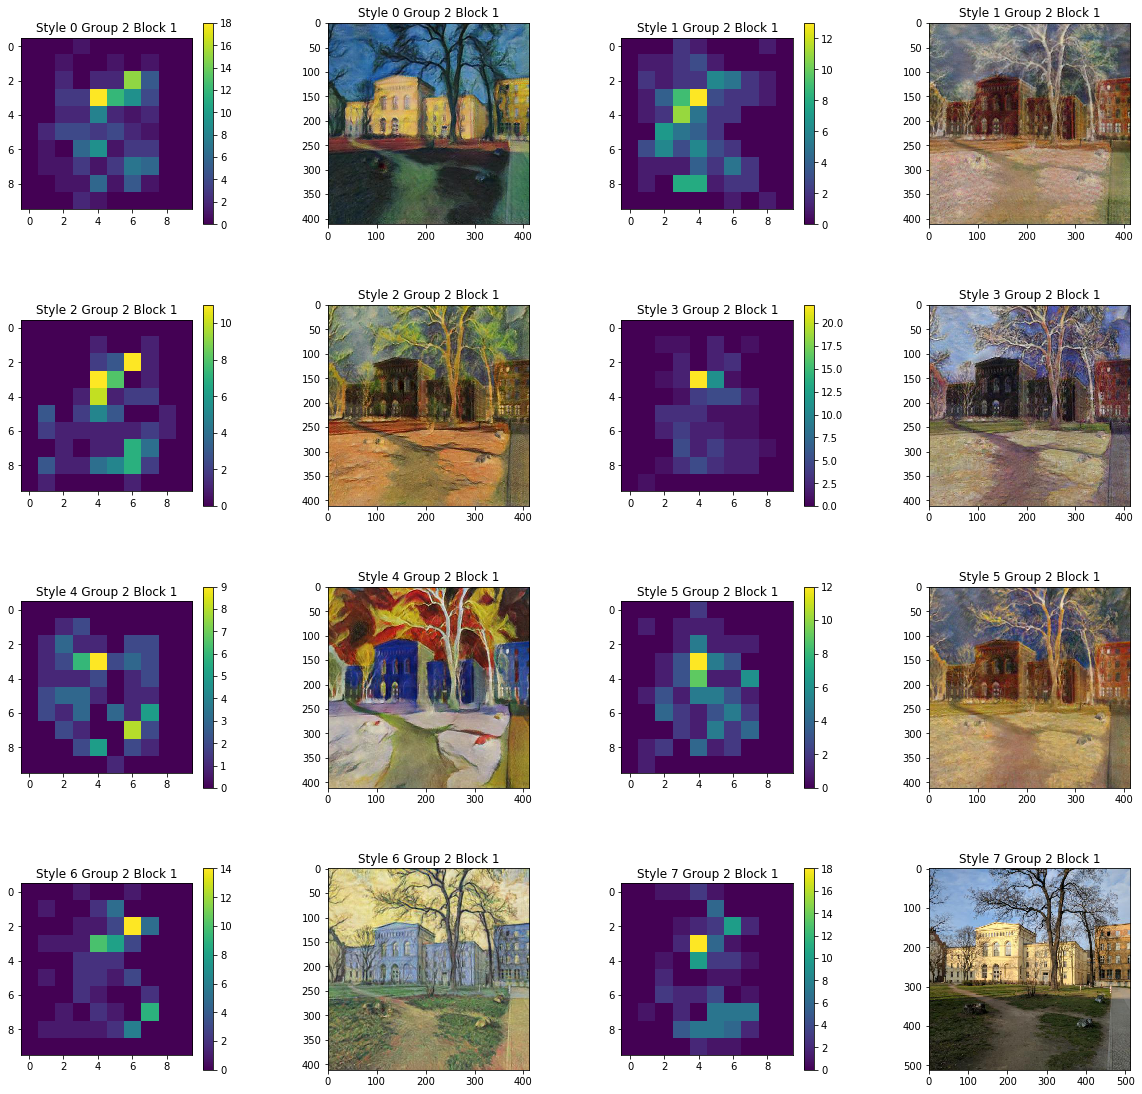

In [31]:
fig = plt.figure(figsize=(20,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n = 1
for g in range(1):
    g = 2
    for b in range(1):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
            ax = fig.add_subplot(8, 4, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            plt.imshow(pictureHM[s])
            plt.colorbar()
            n = n+1
            ax = fig.add_subplot(8, 4, n)
            ax.set_title("Style "+str(s)+" Group "+str(g)+" Block "+str(b+1))
            im = scipy.ndimage.imread(impath+str(s)+"/"+str(g)+"/"+str(b+1)+".jpg")
            plt.imshow(im)
            n = n+1 
#plt.show()
#plt.savefig('Results/ImageHeatmapExample.png')

#### Calculate Heatmap Differences for Each Image

In [137]:
differencesAll = np.zeros((8,8,240))
differencesSumAll = np.zeros((8,8,240))
DotAll = np.zeros((8,8,240))
corrAll = np.zeros((8,8,240))
HeatAll = normalize(np.sum(np.sum(np.sum(heatmaps,axis=1),axis=1),axis=0))
n = 0
for g in range(8):
    for b in range(30):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
        for i in range(8):
            for j in range(8):
                differencesAll[i,j,n] = Differences(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)# same as above and substract grand total such that integral of difference is 0
                differencesSumAll[i,j,n] = np.sum(normalize(pictureHM[i])-normalize(pictureHM[j]))
                DotAll[i,j,n] = np.dot((normalize(pictureHM[i])-HeatAll).flatten(),(normalize(pictureHM[j])-HeatAll).flatten())
                corrAll[i,j,n] = np.arctanh(Correlate(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)[0])
                #calulate correlation and fisher z-transform, calculate mean, then transform back
        n = n+1

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in arctanh


#### Test just for one image

In [126]:
differencesAll = np.zeros((8,8,240))
differencesSumAll = np.zeros((8,8,240))
DotAll = np.zeros((8,8,240))
corrAll = np.zeros((8,8,240))
HeatAll = normalize(np.sum(np.sum(np.sum(heatmaps,axis=1),axis=1),axis=0))
for g in range(1):
    g=2
    for b in range(1):
        b=1
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
        for i in range(8):
            for j in range(8):
                differencesAll[i,j,0] = Differences(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)# same as above and substract grand total such that integral of difference is 0
                differencesSumAll[i,j,0] = np.sum(normalize(pictureHM[i])-normalize(pictureHM[j]))
                DotAll[i,j,0] = np.dot((normalize(pictureHM[i])-HeatAll).flatten(),(normalize(pictureHM[j])-HeatAll).flatten())
                corrAll[i,j,0] = np.arctanh(Correlate(normalize(pictureHM[i])-HeatAll,normalize(pictureHM[j])-HeatAll)[0])

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in arctanh


In [135]:
np.max(DotAll)

0.2761488540152279

#### Plot Difference Matrix and Clustering

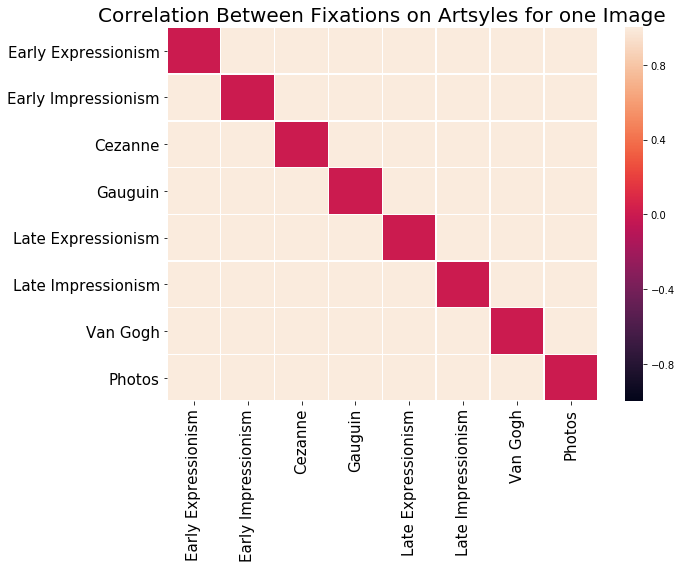

In [138]:
analyze = differencesAll#[:,:,0]
df2 = pd.DataFrame((np.mean(analyze,axis=2)), columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#df2 = pd.DataFrame(analyze, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])

#sns.set()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df2, linewidths=.5, ax=ax,vmin=-1,vmax=1)

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Between Fixations on Artsyles for one Image",fontsize=20)
plt.tight_layout()
#plt.show()
#plt.savefig('Results/StyleFixCorIndvidualExp.png')

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


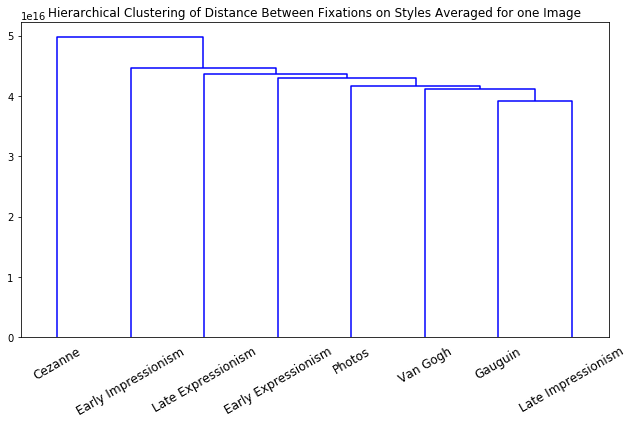

In [141]:
mat = (np.mean(analyze,axis=2))
Z = linkage(mat, 'average')
f, ax = plt.subplots(figsize=(9, 6))
dn = dendrogram(Z,labels=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
plt.xticks(rotation=30)
plt.title("Hierarchical Clustering of Distance Between Fixations on Styles Averaged for one Image")
plt.tight_layout()
#plt.show()
plt.savefig('Results/C_StyleFixDifIndividual.png')

In [91]:
analyze.shape

(8, 8, 240)

#### Linkage Created From Original Distance Matrix

In [ ]:
Z = linkage(np.tanh(np.mean(corrAll,axis=2)), 'average')
f, ax = plt.subplots(figsize=(9, 6))
dn = dendrogram(Z,labels=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
#ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])
plt.xticks(rotation=30)
plt.title("Hierarchical Clustering of Correlation Between Fixations on Styles Averaged Over Images")
plt.tight_layout()
plt.show()
#plt.savefig('Results/StyleFixClusterCorrIndividual.png')

### Look at Distribution of Distances/Dot product/Correlation Over all Motives for each Style Combination
-> This gives us some more nsight into the data and its distribution and explains some of the effect we see in the averaged matrices.

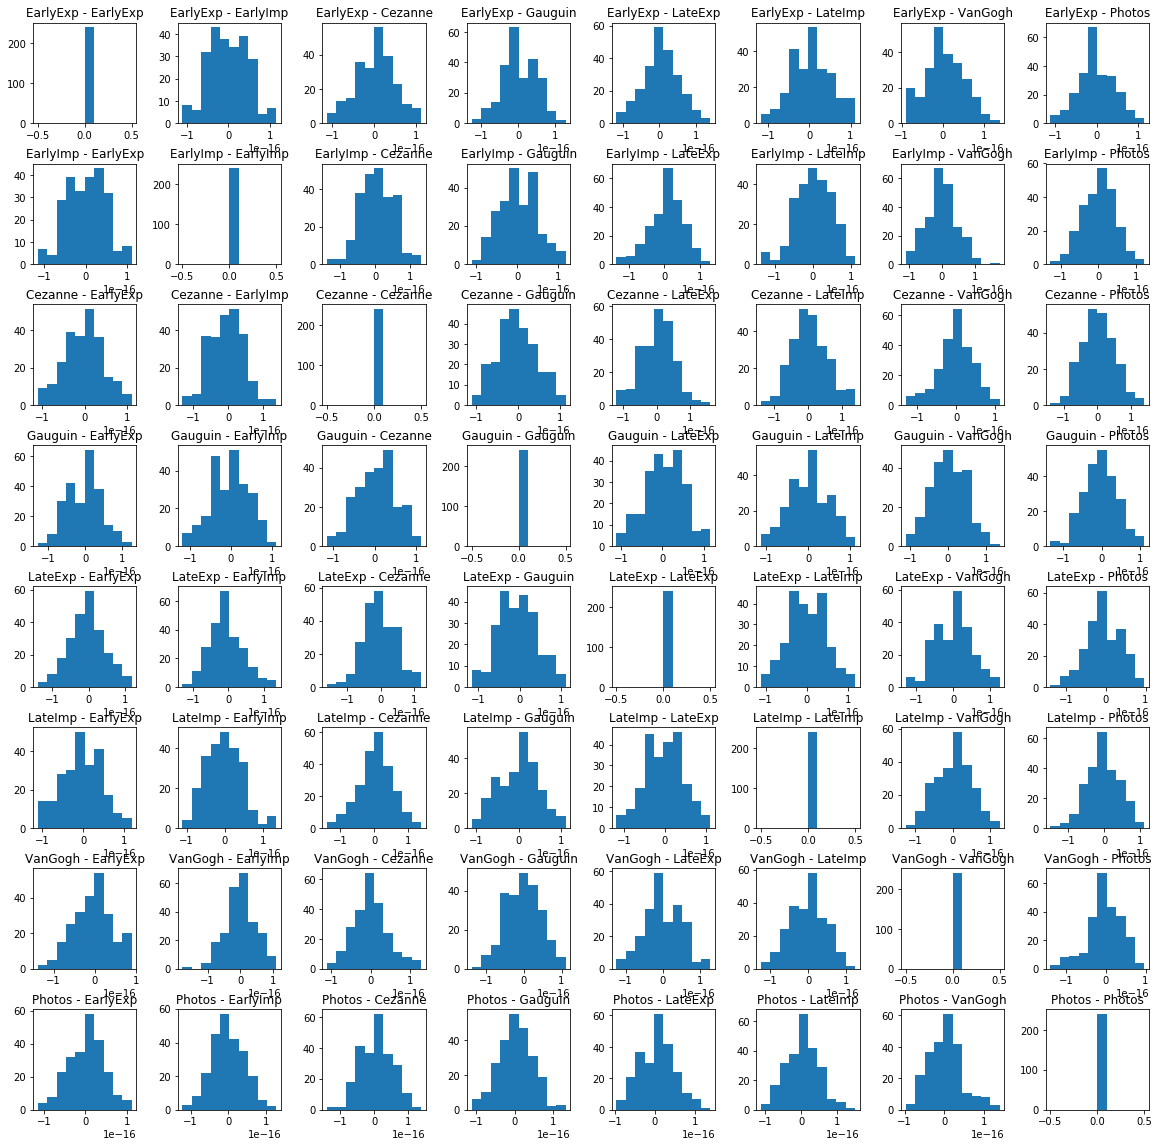

In [136]:
stylesShort = ['EarlyExp', 'EarlyImp', 'Cezanne', 'Gauguin', 'LateExp', 'LateImp', 'VanGogh','Photos']
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n = 1
for i in range(8):
    for j in range(8):
        ax = fig.add_subplot(8, 8, n)
        ax.set_title(stylesShort[i]+" - "+stylesShort[j])
        #plt.hist(np.tanh(corrAll[i][j]), range=(-1, 1))
        plt.hist(differencesSumAll[i][j])
        n=n+1
#plt.savefig("Results/DotDistribution.png")

### Correlations & p-values

In [ ]:
#Calculate 2D matrix where each field contains 240 values -> the difference values for each image 
CorrAll = np.zeros((8,8,240))
n = 0
for g in range(8):
    for b in range(30):
        pictureHM = np.zeros((8,10,10))
        for s in range(8):
            pictureHM[s] = heatmaps[s][g][b]
        for i in range(8):
            for j in range(8):
                diff = Differences(pictureHM[i],pictureHM[j])
                CorrAll[i,j,n] = diff
        n = n+1

In [ ]:
Corrs = np.zeros((8,8))
Ps = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        Corrs[i][j],Ps[i][j] = scipy.stats.pearsonr(CorrAll[i][j],np.random.normal(np.mean(CorrAll),np.var(CorrAll),240))       

In [ ]:
dfPs = pd.DataFrame(Ps, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dfPs, linewidths=.5, ax=ax,annot=True)

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("p-values for Difference Distributions",fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
dfCorrs = pd.DataFrame(Corrs, columns=['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'])

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dfCorrs, linewidths=.5, ax=ax,annot=True)

ax.set_yticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
ax.set_xticklabels(['Early Expressionism', 'Early Impressionism', 'Cezanne', 'Gauguin', 'Late Expressionism', 'Late Impressionism', 'Van Gogh','Photos'],fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlations between for Difference Distribution of Style Combination with Overall Distribution",fontsize=15)
plt.tight_layout()
plt.show()

### Class Balance  (Just to Double Check)

#### Over Groups:

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.04, wspace=0.4)
for s in range(8):
    ax = fig.add_subplot(4,2,s+1)
    sns.barplot(np.linspace(1,30,30),sum(blockdist[s]))
plt.show()

#### Over Styles:

In [ ]:
blockdist = np.zeros((8,8,30))
Discard = [24]
#in folder structure: stimuli/stylenum/groupnum/blocknum
#same image with different style: stylex/gn/bn == styley/gn/bn
#8 trials per block, one of each style
stylenum = np.zeros(8)
for s in range(64):
    style1 = np.zeros(8)
    #print(s)
    if (s+1) in Discard:
        print(str(s+1)+" discarded.")
    else:
        if s<9:
            num = '00'+str(s+1)
        else:
            num = '0'+str(s+1)
        mat = spio.loadmat(path+'SUB'+num+'.mat', squeeze_me=True, struct_as_record=False)
        data = mat['file']
        fx,fy,t,b,g,st = getTrialFixations(data)
        
        for num in range(1,241):
            PickRange = np.where(t==num)

            style = np.unique(st[PickRange])
            group = np.unique(g[PickRange])
            block = np.unique(b[PickRange])
            
            try:
                blockdist[int(style)-1][int(group)][int(block)-1]=blockdist[int(style)-1][int(group)][int(block)-1]+1
                stylenum[int(style)-1] = stylenum[int(style)-1]+1
                style1[int(style)-1] = style1[int(style)-1]+1
            except:
                try:
                    print(style)
                    blockdist[int(style[-1])-1][int(group[-1])][int(block[-1])-1]=blockdist[int(style[-1])-1][int(group[-1])][int(block[-1])-1]+1
                    stylenum[int(style[-1])-1] = stylenum[int(style[-1])-1]+1
                    style1[int(style[-1])-1] = style1[int(style[-1])-1]+1
                except:
                    print("Problem with "+str(s+1)+" Trial "+str(num))
        print(style1)

In [ ]:
plt.bar(np.linspace(1,8,8),stylenum)
plt.show()